Sunspots Analysis

In [88]:
%%script "C:\Users\Glenn.Herpoelaert\AppData\Local\Programs\Python\Python37\python.exe"
import sys
#print(sys.version)

In [94]:
#importing packages
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import csv
import datetime
import warnings
import statsmodels.api as sm   
import tensorflow as tf
from tensorflow import keras
from itertools import product    
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import dates as mpl_dates

#update sns
#import sys
#!{sys.executable} -m pip install seaborn

# Introduction

> In this document a univariate timeseries is being analysed. First the data is being explored. After the exploration 3 different kinds of models are being developed: a naive forecast, an ARIMA model and finaly a Facebook Prophet model.

# The Data

> Datasources: https://www.kaggle.com/robervalt/sunspots and http://www.sidc.be/silso/datafiles

> The database comes from SIDC - Solar Influences Data Analysis Center - the solar physics research department of the Royal Observatory of Belgium. 

> Description from Wikipedia (https://en.wikipedia.org/wiki/Sunspot): Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

In [95]:
#importing the data
df_sunspots = pd.read_csv('sunspots.csv',parse_dates=['Date'],index_col='Date')


# Data exploration

##### Exploring the datatypes

In [96]:
df_sunspots.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3235 entries, 1749-01-31 to 2018-07-31
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3235 non-null   int64  
 1   Monthly Mean Total Sunspot Number  3235 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.8 KB


> We can see that the dataset has a limited amount of colums. 2 columns are numerical (int and float) and 1 column is an object. The first column also does not have a columnname. The dataset contains 3235 rows. We don't see any missings.

In [97]:
df_sunspots.head()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


> We see:
- one column with an autonumber, not adding any value
- a date which ends each time at the end of the month
- a numerical colum with floats with the monthly mean total sunspot number

In [98]:
df_sunspots.tail()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
2018-03-31,3230,2.5
2018-04-30,3231,8.9
2018-05-31,3232,13.2
2018-06-30,3233,15.9
2018-07-31,3234,1.6


> The dataset starts on Januari 1749 and goes until July 2018.

> The first column is a surrogate key with an autonumber this column runs parallel with the index and may be deleted.

In [99]:
#deleting the autonumber column
df_sunspots.drop('Unnamed: 0',axis=1, inplace =True)


In [100]:
#renaming columns
df_sunspots.columns = ['Monthly_mean_total_sunspots']

##### Statistical information

In [101]:
df_sunspots.describe()

,Monthly_mean_total_sunspots
count,3235.000000
mean,82.481082
std,67.805190
min,0.000000
25%,24.750000
50%,68.300000
75%,122.900000
max,398.200000


> The average amount of sunspots per month goes from 0 until 398.2

# Data visualisation

##### Boxplot

Text(0.5, 0, 'Monthly mean total sunspots')

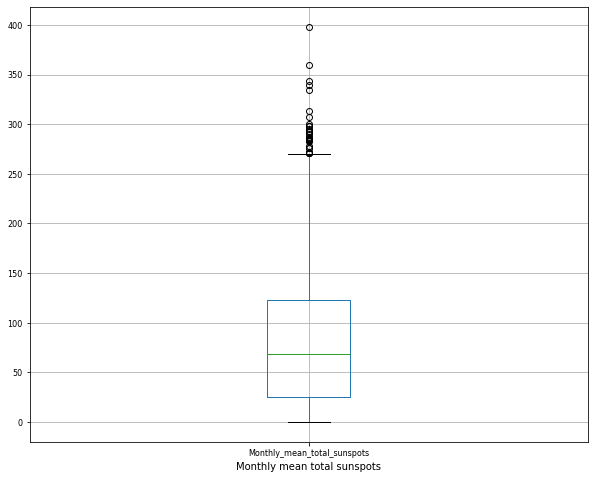

In [102]:
#boxplot with average temperatures

ax = df_sunspots.boxplot(column='Monthly_mean_total_sunspots',fontsize=8,figsize=(10,8))
ax.set_xlabel('Monthly mean total sunspots', fontsize=10)

> In the boxplot above there are some outliers at the higher end of the spectrum. The impact of these outliers on the model could be checked later.

##### Violin plot

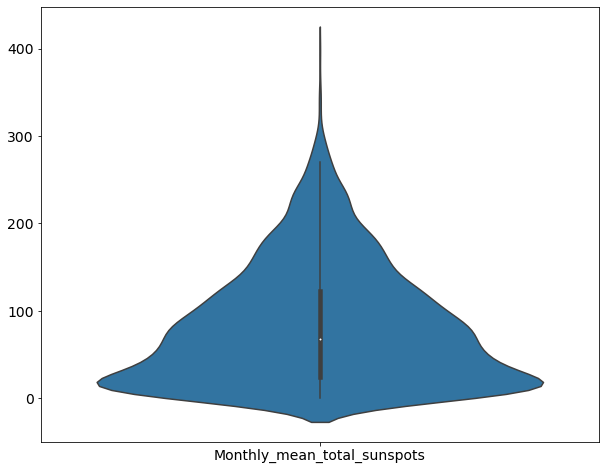

In [103]:
#violinplot with average temperatures
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})
ax = sns.violinplot(data=df_sunspots)

> The violin plot gives a better idea of the data distribution in comparison with the boxplot. The main part of the months have a total amount of sunspots between 0 and 100.

##### Density plot

Text(0, 0.5, 'Density plot of Monthly mean total sunspots')

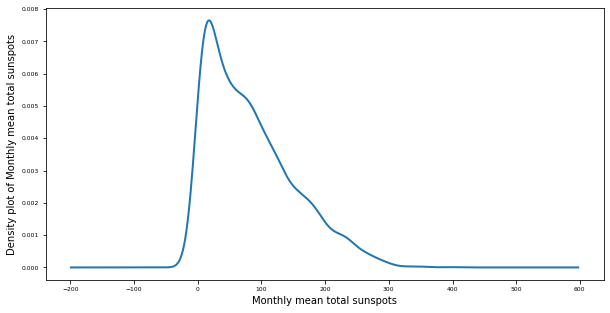

In [104]:
#data distribution
#density plot of land average temperatures to assess the distribution of the data

ax = df_sunspots['Monthly_mean_total_sunspots'].plot(kind='density', linewidth=2, fontsize=6, figsize=(10,5))
ax.set_xlabel('Monthly mean total sunspots', fontsize=10)
ax.set_ylabel('Density plot of Monthly mean total sunspots', fontsize=10)

> The information we get from the density plot is similar to that of the violin plot. 
The peak of the density plot is close to 0. After that the frequency of occurence of the total mean sunspots gradually goes down. This is less visible on the boxplot but very visible on the violin plot.

##### Plotting the data on a timeline

Text(0, 0.5, 'Monthly mean total sunspots')

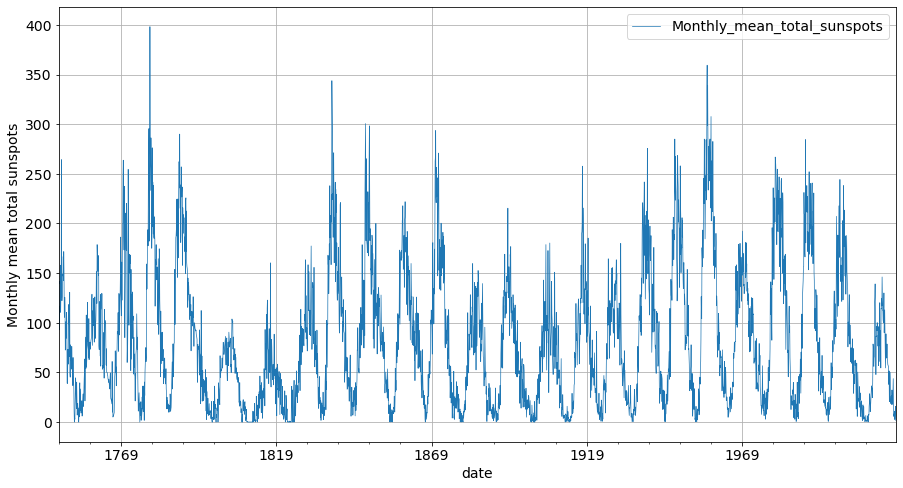

In [105]:
rcParams['figure.figsize'] = 15, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = df_sunspots.plot( grid=True,linewidth=0.7)

ax.plot()
    
ax.set_xlabel("date")
ax.set_ylabel("Monthly mean total sunspots")

> We are dealing with a univariate timeseries because the dataset only has 1 response variable. In the plot above we can't immediately see an upward or downward trend. 


> According to Wikipedia, the average amount of sunspots has a cycle of 11 years (https://en.wikipedia.org/wiki/Solar_cycle). Suchlike seasonality is indeed something we can see on the plot. Although it is difficult to see that it is indeed around 11 years (in case of the dataset 132 months).

##### Plotting quantiles to show the volatility of the amount of sunspots

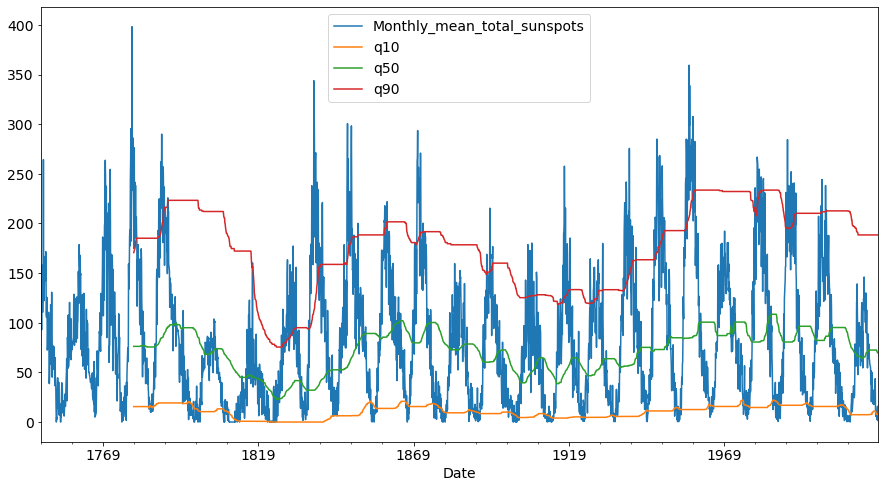

In [106]:
df_sunspots_q = df_sunspots.copy()
rolling = df_sunspots.Monthly_mean_total_sunspots.rolling(360)

# Insert the rolling quantiles to the monthly returns
df_sunspots_q['q10'] = rolling.quantile(0.1).to_frame('q10')
df_sunspots_q['q50'] = rolling.quantile(0.5).to_frame('q50')
df_sunspots_q['q90'] = rolling.quantile(0.9).to_frame('q90')

df_sunspots_q.loc[:,['Monthly_mean_total_sunspots','q10','q50','q90']].plot(figsize=(15,8))
plt.show()


> The plot above shows that the mean total sunspots can be quite volatile accross time.

##### Downsampling to an annual level

In [107]:

df_yearly = df_sunspots.resample('AS').mean()

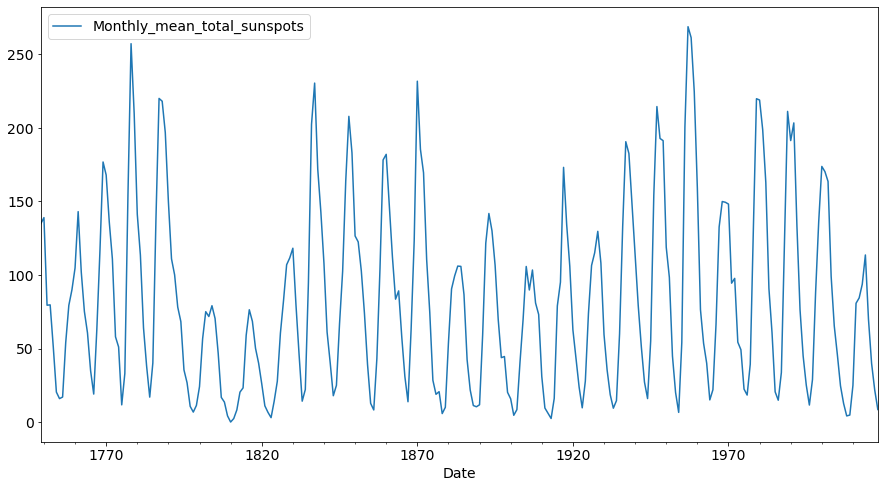

In [108]:
df_yearly[['Monthly_mean_total_sunspots']].plot(kind='line',figsize=(15,8))


> As the solar cycle  is a nearly periodic 11-year change in the Sun's activity measured, it makes sense to downsample the data to a yearly level. This results in a much smoother plot without loosing the view on the cycles.

#### Seasonality in detail

<Figure size 864x432 with 0 Axes>

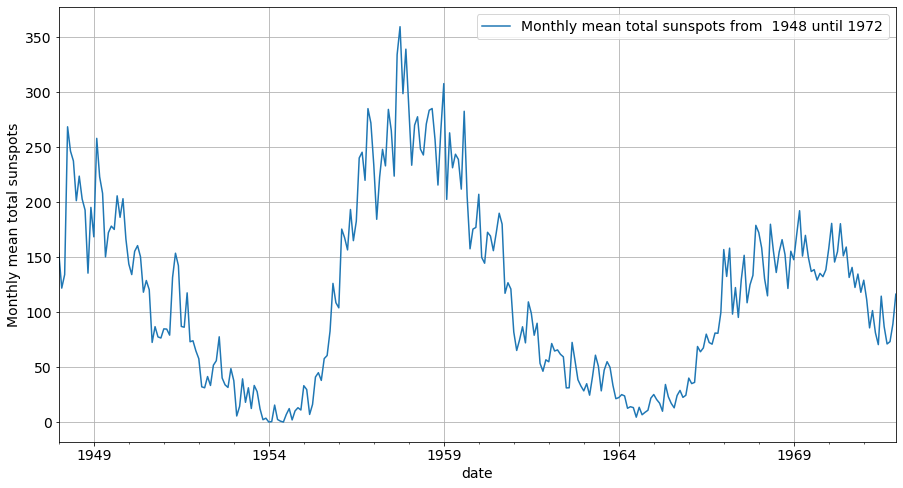

In [109]:
fig = plt.figure(figsize = (12,6))

df_ranged = df_sunspots.loc[(df_sunspots.index > '1948-01-01') & (df_sunspots.index < '1972-01-01')]

# Plot the predictions
rcParams['figure.figsize'] = 15, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = df_ranged.plot( grid=True)

# Plot the predictions
ax.plot()
    
ax.set_xlabel("date")
ax.set_ylabel("Monthly mean total sunspots")
ax.legend(['Monthly mean total sunspots from  1948 until 1972'])

> The monthly amount of sunspots indeed reaches a minimum at 1954, wich recurs eleven years later at 1965. This is in line with the 11 year cycle.

<Figure size 864x432 with 0 Axes>

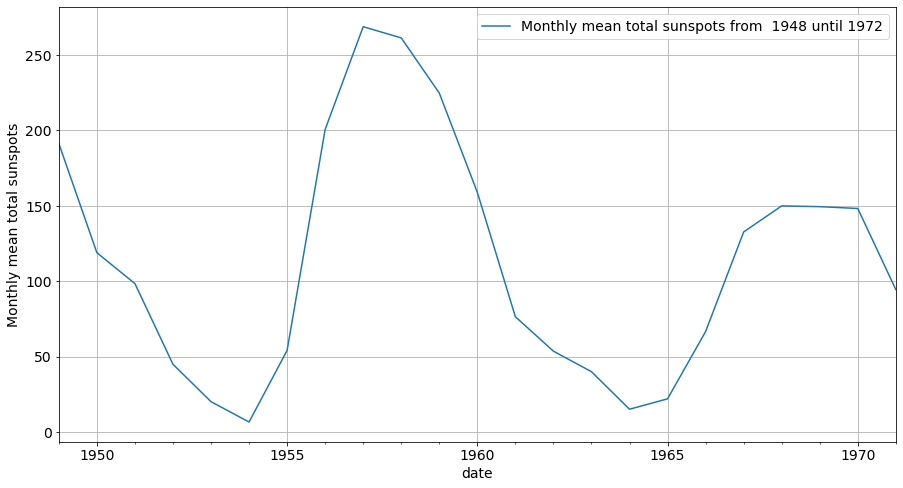

In [20]:
fig = plt.figure(figsize = (12,6))

df_ranged = df_yearly.loc[(df_yearly.index > '1948') & (df_yearly.index < '1972')]

# Plot the predictions
rcParams['figure.figsize'] = 15, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = df_ranged.plot( grid=True)

# Plot the predictions
ax.plot()
    
ax.set_xlabel("date")
ax.set_ylabel("Monthly mean total sunspots")
ax.legend(['Monthly mean total sunspots from  1948 until 1972'])

> On the smoothed plot we see the same information except that the mimimum seems to lie here at 1964 instead of 1965.

<Figure size 864x432 with 0 Axes>

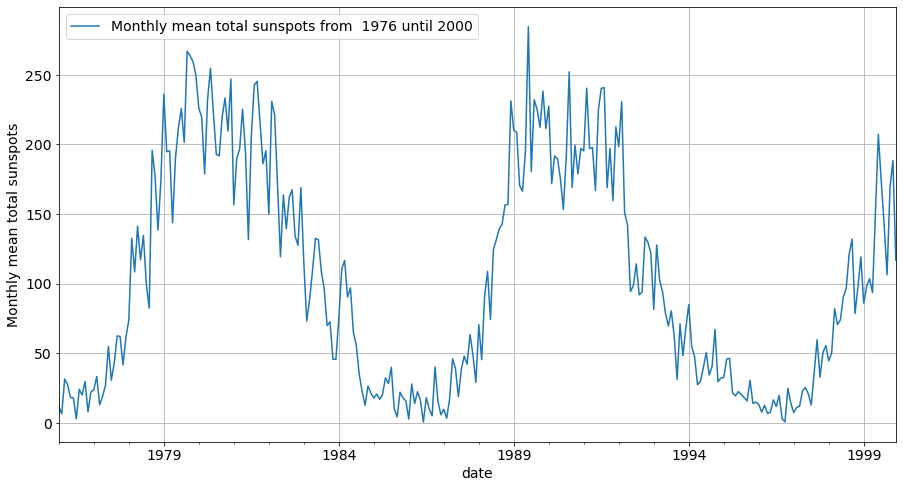

In [21]:
fig = plt.figure(figsize = (12,6))

df_ranged = df_sunspots.loc[(df_sunspots.index > '1976-01-01') & (df_sunspots.index < '2000-01-01')]

# Plot the predictions
rcParams['figure.figsize'] = 15, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = df_ranged.plot(grid=True)

# Plot the predictions
ax.plot()
    
ax.set_xlabel("date")
ax.set_ylabel("Monthly mean total sunspots")
ax.legend(['Monthly mean total sunspots from  1976 until 2000'])

> In this plot we see the same pattern: a minimum at 1986 which recurrs at around 1997.

#### Timeseries decomposition

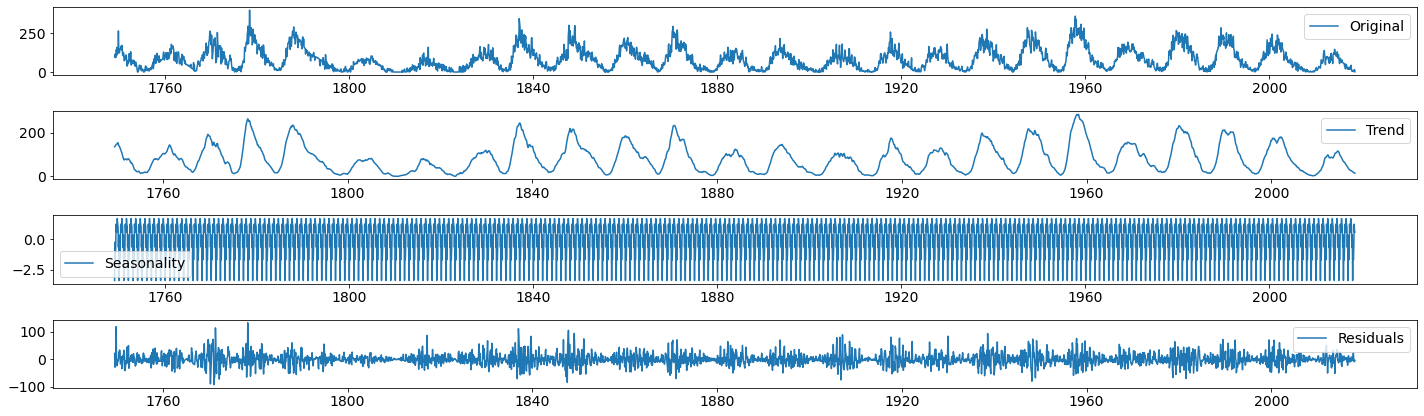

In [22]:
#additief model: monthly data
plt.figure(figsize=(20, 6))
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_sunspots,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_sunspots, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

###### Seasonality:
> In the output above we see seasonality data. But the range is very limited [-4,2] and it is a very repetitve pattern without any evolution.

###### Trend:
> The data clearly has a trend. The range between the minimum and the maximum can be quite high.
###### Residuals:
> We see that there is noise in the dataset.

##### Additive model for the resampled dataset

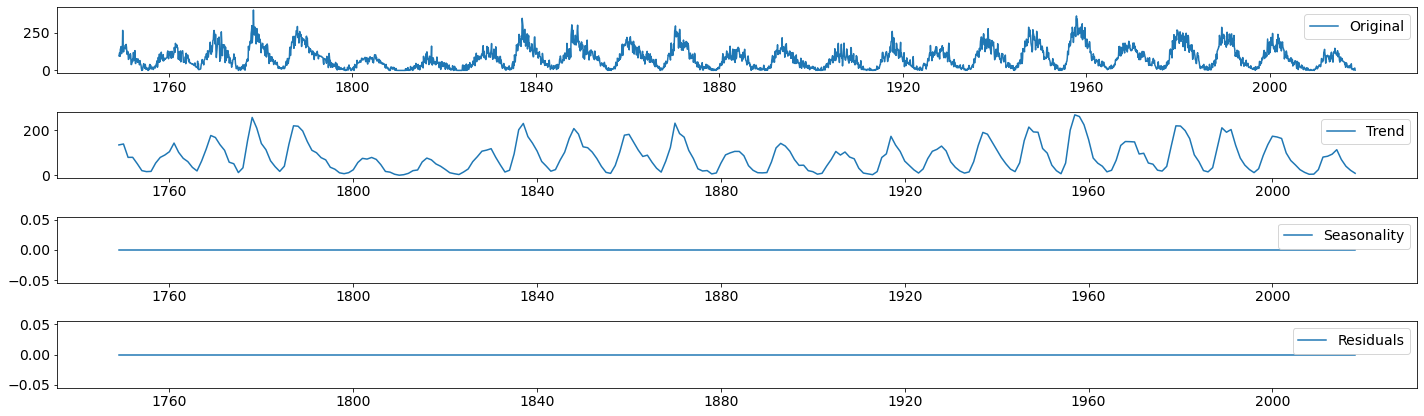

In [23]:
plt.figure(figsize=(20, 6))
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_yearly,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_sunspots, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

> If we look at the downsampled data. We still have the same trend, but the seasonality and the residuals have evolved to a flat line staying at 0.

##### Multiplicative model

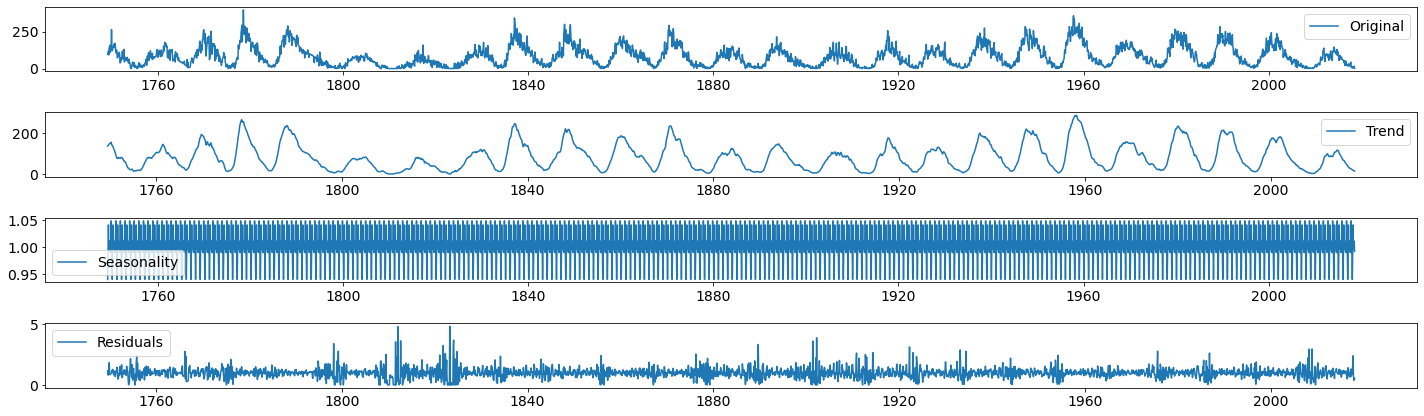

In [111]:
#replacing 0 values with a very small number to be able to calculate the model
df_sunspots_mp = df_sunspots.copy()
df_sunspots_mp[df_sunspots.Monthly_mean_total_sunspots ==0] = 0.0000000000001

plt.figure(figsize=(20, 6))
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_sunspots_mp,model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_sunspots_mp, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

> The multiplicative model does not give anymore insights than that the addive model does.

##### Range between min en max

In [25]:
df_sunspots.Monthly_mean_total_sunspots.max() - df_sunspots.Monthly_mean_total_sunspots.min()

398.2

> The range between the min and maximum value is rather large (398.2). Because of this the Mean absolute error will play a key role to evaluate the models because it takes larege errors less into account.

### Train/test split

> We split the dataset in a training set and a testing set.

In [26]:
#selecting training and testing data
train_val_size = len(df_sunspots)

#training data = 70%, test data=30%
TrainingSize = int(train_val_size * 0.7)
df_trainingdata = df_sunspots[0:TrainingSize]
df_testdata = df_sunspots[TrainingSize:train_val_size]

In [27]:
#checking whether the train and test data are sequencing eachother
df_trainingdata.index.values.max(), df_testdata.index.values.min() 

(numpy.datetime64('1937-08-31T00:00:00.000000000'),
 numpy.datetime64('1937-09-30T00:00:00.000000000'))

## Naive Forecast

> For starters we have a look at a naive forecast with a horizon of 1 month.

In [29]:
naive_forecast = df_sunspots.copy()
#naive_forecast = naive_forecast[TrainingSize:-1].copy()
naive_forecast['naive_forecast'] = naive_forecast.Monthly_mean_total_sunspots.shift(1)
naive_forecast = naive_forecast[1:-1]
naive_forecast.head()


,Monthly_mean_total_sunspots,naive_forecast
Date,,
1749-02-28,104.3,96.7
1749-03-31,116.7,104.3
1749-04-30,92.8,116.7
1749-05-31,141.7,92.8
1749-06-30,139.2,141.7


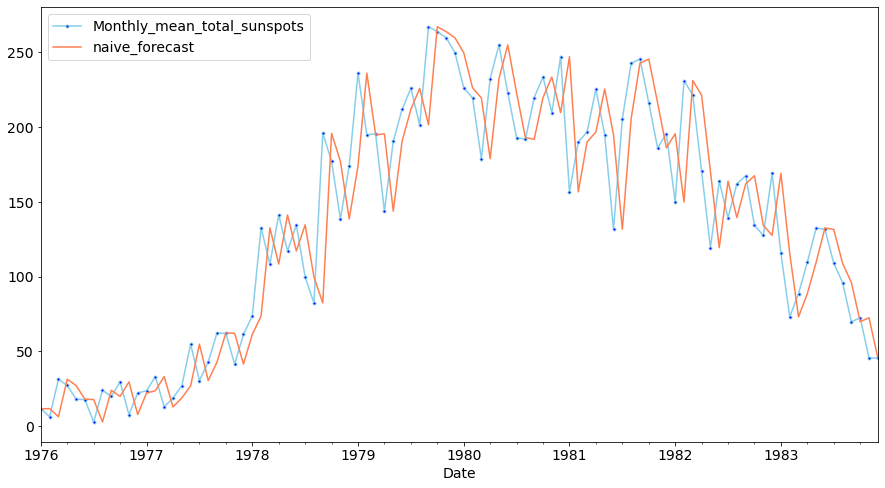

In [30]:
#zooming in to better see the difference
df_ranged_naive = naive_forecast.loc['1976-01-01':'1984-01-01']

df_ranged_naive['Monthly_mean_total_sunspots'].plot( marker='o', markerfacecolor='blue', markersize=3, color='skyblue')

df_ranged_naive['naive_forecast'].plot( marker='', color='coral')

plt.legend()
plt.show()

##### Evaluation

In [31]:
print('Mean absolute error:',keras.metrics.mean_absolute_error(naive_forecast.Monthly_mean_total_sunspots, naive_forecast.naive_forecast).numpy())
print('Mean squared errror: ', keras.metrics.mean_squared_error(naive_forecast.Monthly_mean_total_sunspots, naive_forecast.naive_forecast).numpy())
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(naive_forecast.Monthly_mean_total_sunspots, naive_forecast.naive_forecast)
print('Mean absolute percentage error: ', m.result().numpy())



Mean absolute error: 19.385648004948965
Mean squared errror:  760.2117661614596
Mean absolute percentage error:  75378940.0


> We will use the MAE of 19.89 as the baseline. This makes that large errors will be dealt with on a smoother way in comparison with the MSE.

> In what follows we will elaborate a the Naive forecast a little bit more. First with a little larger horizon to see if the MAE rises what is expected with a Naive forecast. After that we will put the horizon on 11 years (132 months) which equals the duration of the solar cycle.

##### MAE with a larger horizon

In [113]:
H = 132//2
naive_forecast_hz_l = df_sunspots.copy()
#naive_forecast_hz_l = naive_forecast_hz_l[TrainingSize:-1].copy()
naive_forecast_hz_l['naive_forecast'] = naive_forecast_hz_l['Monthly_mean_total_sunspots'].shift(periods=H)
naive_forecast_hz_l = naive_forecast_hz_l[H:]


In [114]:
naive_forecast_hz_l.head()

,Monthly_mean_total_sunspots,naive_forecast
Date,,
1754-07-31,31.3,96.7
1754-08-31,20.5,104.3
1754-09-30,13.7,116.7
1754-10-31,40.2,92.8
1754-11-30,22.0,141.7


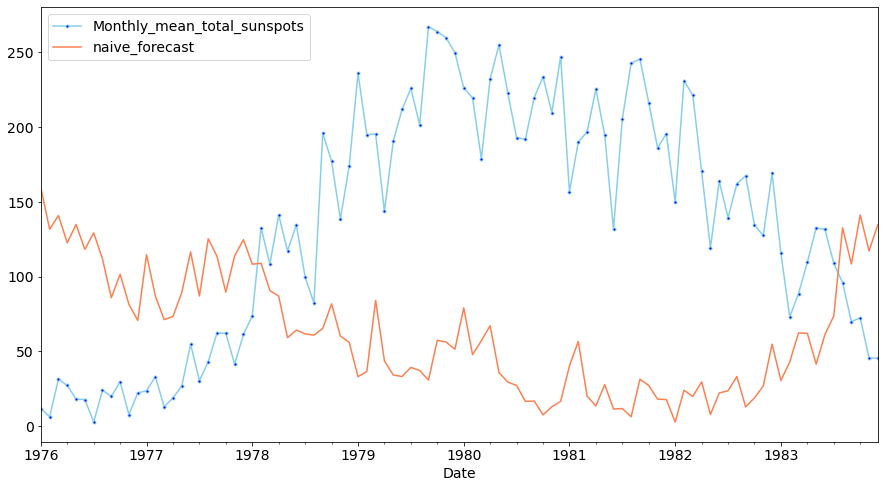

In [115]:
df_ranged_naive_hz_l = naive_forecast_hz_l.loc['1976-01-01':'1984-01-01']

df_ranged_naive_hz_l['Monthly_mean_total_sunspots'].plot( marker='o', markerfacecolor='blue', markersize=3, color='skyblue')

df_ranged_naive_hz_l['naive_forecast'].plot( marker='', color='coral')

plt.legend()
plt.show()


##### Evaluation

In [117]:
print('Mean absolute error:',keras.metrics.mean_absolute_error(naive_forecast_hz_l.Monthly_mean_total_sunspots, naive_forecast_hz_l.naive_forecast).numpy())
print('Mean squared errror: ', keras.metrics.mean_squared_error(naive_forecast_hz_l.Monthly_mean_total_sunspots, naive_forecast_hz_l.naive_forecast).numpy())
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(naive_forecast_hz_l.Monthly_mean_total_sunspots, naive_forecast_hz_l.naive_forecast)
print('Mean absolute percentage error: ', m.result().numpy())



Mean absolute error: 98.06434206374252
Mean squared errror:  13395.330574313668
Mean absolute percentage error:  1673146500.0


> With a horizon of 66 months we see that the MAE rises a lot to a value of 121. 

##### Horizon of 11 years (132 months)

In [36]:
H = 132
naive_forecast_hz_l2 = df_sunspots.copy()
#naive_forecast_hz_l = naive_forecast_hz_l[TrainingSize:-1].copy()
naive_forecast_hz_l2['naive_forecast'] = naive_forecast_hz_l2['Monthly_mean_total_sunspots'].shift(periods=H)
naive_forecast_hz_l2 = naive_forecast_hz_l[H:]


In [37]:
print('Mean absolute error:',keras.metrics.mean_absolute_error(naive_forecast_hz_l2.Monthly_mean_total_sunspots, naive_forecast_hz_l2.naive_forecast).numpy())
print('Mean squared errror: ', keras.metrics.mean_squared_error(naive_forecast_hz_l2.Monthly_mean_total_sunspots, naive_forecast_hz_l2.naive_forecast).numpy())
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(naive_forecast_hz_l2.Monthly_mean_total_sunspots, naive_forecast_hz_l2.naive_forecast)
print('Mean absolute percentage error: ', m.result().numpy())



Mean absolute error: 99.31007573263089
Mean squared errror:  13676.33943035891
Mean absolute percentage error:  1612084600.0


> When we take a horizon of 132 months, the MAE drops again in comparison with the MAE of a horizon of 66 months. It still is double the amount of a horion of 1 month.

##### MAE per horizon

In [38]:
predsMAE=[]
predsMSE=[]
for i in range(1,132*4):
    H=i
    naive_forecast_hz_l3 = df_sunspots[TrainingSize:-1].copy()
    naive_forecast_hz_l3['pred'] = naive_forecast_hz_l['Monthly_mean_total_sunspots'].shift(periods=H)
    naive_forecast_hz_l3 = naive_forecast_hz_l3[H:]
    predMAE = keras.metrics.mean_absolute_error(naive_forecast_hz_l3.Monthly_mean_total_sunspots, naive_forecast_hz_l3.pred).numpy()
    predsMAE.append(predMAE)
    predMSE = keras.metrics.mean_squared_error(naive_forecast_hz_l3.Monthly_mean_total_sunspots, naive_forecast_hz_l3.pred).numpy()
    predsMSE.append(predMSE)
    

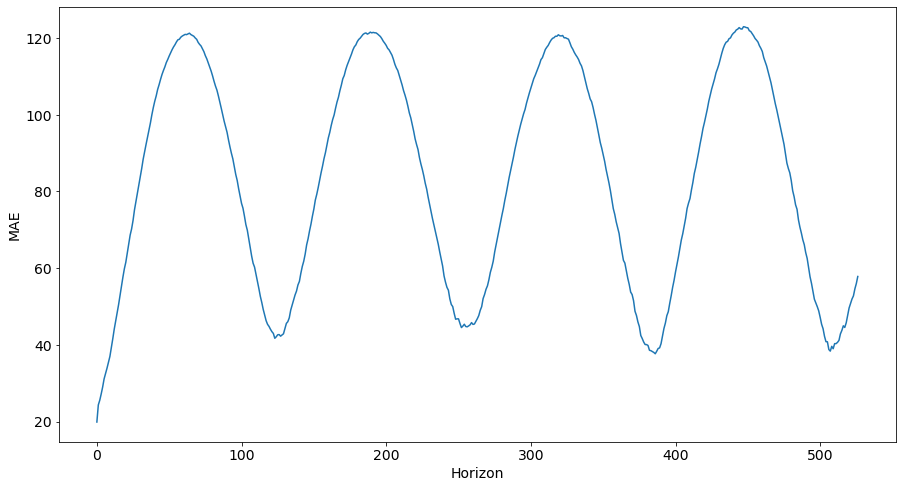

In [39]:
plt.ylabel('MAE')
plt.xlabel('Horizon')
plt.plot(predsMAE)
#plt.plot(predsMSE)

> We clearly can see a sine wave like pattern. The lowest MAE is at the beginning. After that there is a repetitive cycle at about every 132 months (11 years). This confirms the existance of the solar cycle.

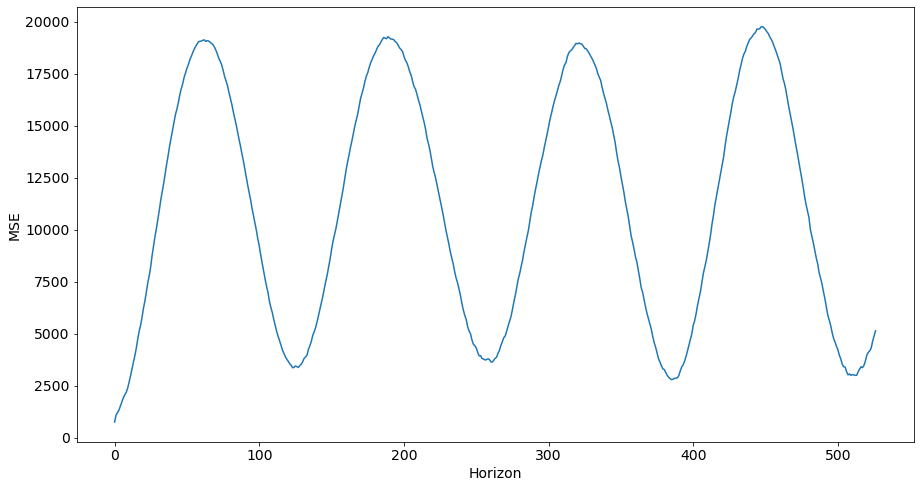

In [40]:
plt.ylabel('MSE')
plt.xlabel('Horizon')
plt.plot(predsMSE)

> We have a likewise pattern with the MSE. The big difference is that the range between the minimum value and the maximum value is a lot bigger then those of the MAE plot. This totally makes sence because the MSE uses the square roots.

## Arima Model

#### Stationarity Check

##### Is the amount of sunspots a random walk?

In [122]:
avg_sunspots = pd.DataFrame(df_sunspots.loc[:,'Monthly_mean_total_sunspots'])
avg_sunspots.index = pd.to_datetime(avg_sunspots.index,format='%Y' )

result = adfuller(avg_sunspots['Monthly_mean_total_sunspots'])
print("The p-value for the ADF test is", result[1])


The p-value for the ADF test is 1.1370331890118992e-18


In [42]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='dodgerblue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

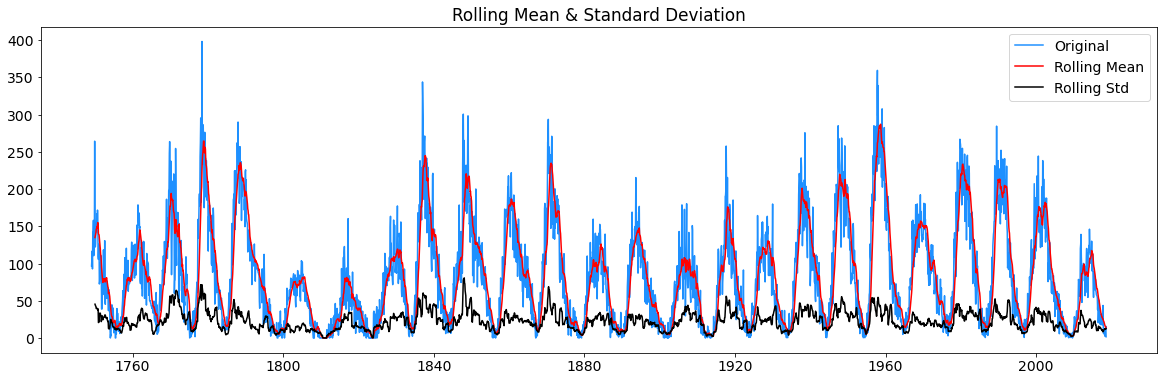

Results of Dickey-Fuller Test:
Test Statistic                -1.049256e+01
p-value                        1.137033e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.206000e+03
Critical Value (1%)           -3.432391e+00
Critical Value (5%)           -2.862442e+00
Critical Value (10%)          -2.567250e+00
dtype: float64


In [43]:
plt.figure(figsize=(20, 6))
test_stationarity(df_sunspots)

> The p-value is extremely small, so we can reject the hypothesis that returns are a random walk at all levels of significance. We can also see this visualy in the plot where the rolling mean and rolling std keep hanging around the same values. Because we have a stationary dataset we can immediately start modeling without differentiating.

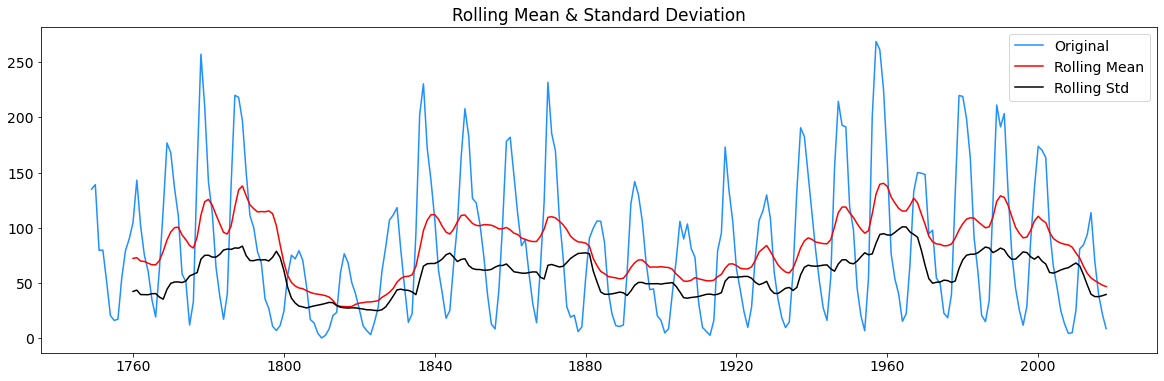

Results of Dickey-Fuller Test:
Test Statistic                  -2.803741
p-value                          0.057741
#Lags Used                       8.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


In [44]:
plt.figure(figsize=(20, 6))
test_stationarity(df_yearly)

> The results of the smoothed data are different. Here the data is non-stationary. In order to build an arima model we would need to differentiate the data. 

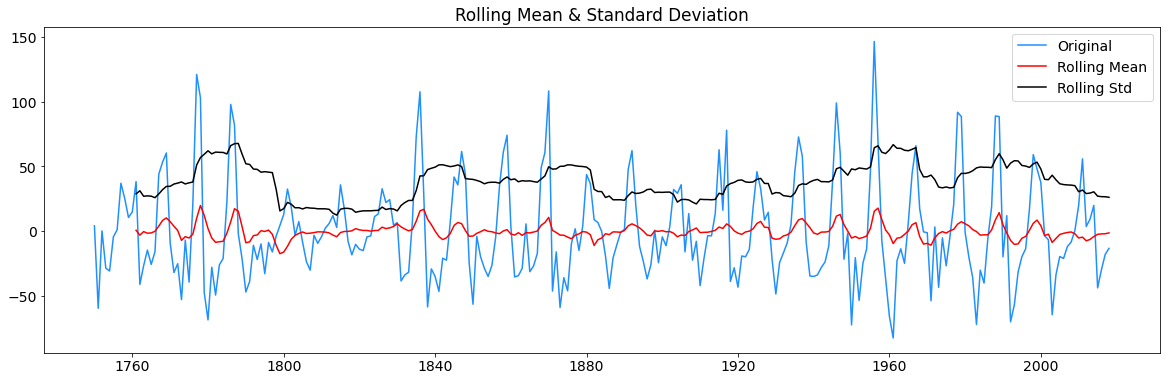

Results of Dickey-Fuller Test:
Test Statistic                -1.336984e+01
p-value                        5.224411e-25
#Lags Used                     7.000000e+00
Number of Observations Used    2.610000e+02
Critical Value (1%)           -3.455656e+00
Critical Value (5%)           -2.872678e+00
Critical Value (10%)          -2.572705e+00
dtype: float64


In [45]:
plt.figure(figsize=(20, 6))
test_stationarity(df_yearly.diff().dropna())

> A one time differentiation suffices for the smoothed data. The p-value is now below 0.05.

#### Autocorrelation

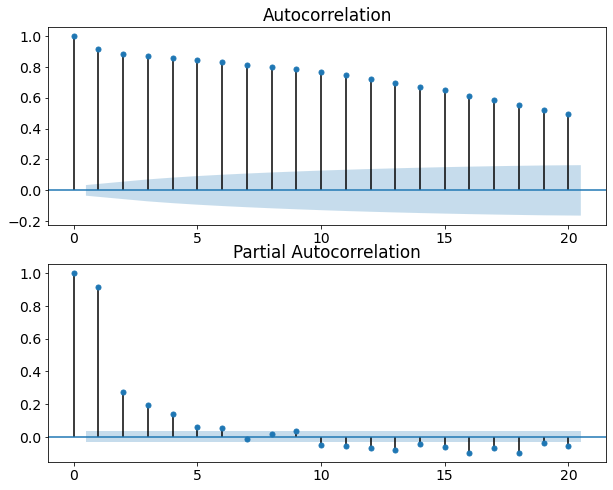

In [46]:
#inspecting autocorrelation and partial autocorrelation of the monthly level dataset: 20 lags

fig, axes = plt.subplots(2,1,figsize=(10,8))

# ACF
plot_acf(df_sunspots, lags=20, ax=axes[0])

# PACF
plot_pacf(df_sunspots, lags=20, ax=axes[1])
plt.show()

> When we look at the first 20 lags, the autocorrelation plot shows that consecutive observations are positively correlated with one another. All values here are statistically significant.

> In the partial autocorrelation plot of 20 lags the correlation is also positive, but it quickly dissolves to values close to 0 or even slightly negative values. Not all values here are statistically significant.

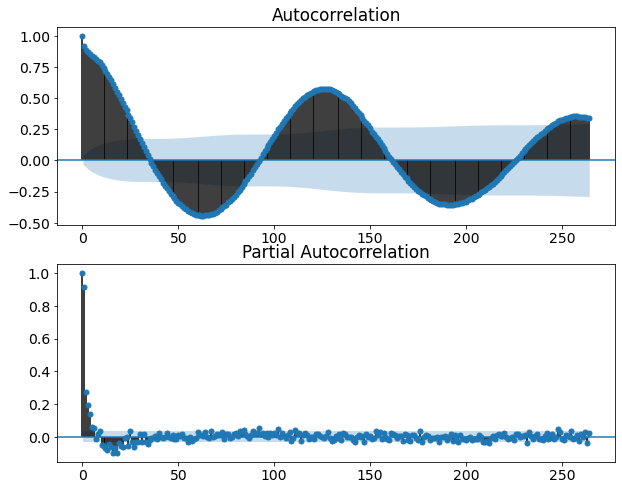

In [47]:
#inspecting autocorrelation and partial autocorrelation of the monthly level dataset: 2 cycles of 11 years

fig, axes = plt.subplots(2,1,figsize=(10,8))

# ACF
plot_acf(df_sunspots, lags=132*2, ax=axes[0])

# PACF
plot_pacf(df_sunspots, lags=132*2, ax=axes[1])
plt.show()

> In the plots above, we took a lag of 2 solar cycles (22 years). For the autocorrelation we see that the correlation is switching between positive correlations and negative correlations. Not all values are statistically significant. The pattern of the autocorrelation plot is in line with what we have seen in the naive forecast models.

> The partial autocorrelation starts with a positive correlation, but the values quickly go close to 0.

##### Inspecting autocorrelation and partial autocorrelation of the yearly level dataset

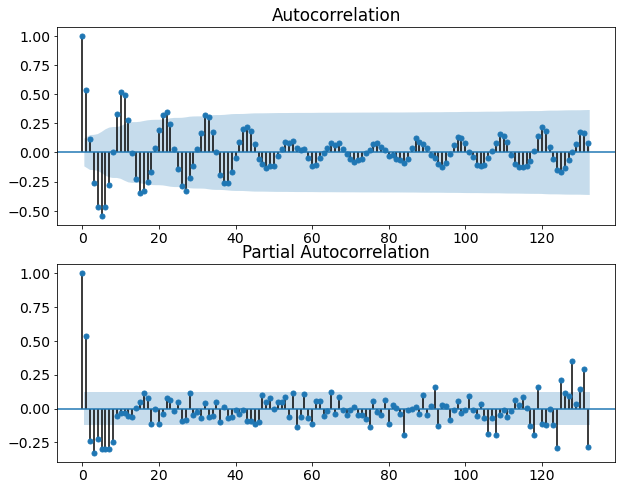

In [48]:
chg_sunspots = df_yearly.diff()
chg_sunspots = chg_sunspots.dropna()

fig, axes = plt.subplots(2,1,figsize=(10,8))

# ACF
plot_acf(chg_sunspots, lags=132, ax=axes[0])

# PACF
plot_pacf(chg_sunspots, lags=132, ax=axes[1])
plt.show()

> Also in the autocorrelation and partion autocorrelation plots of the downsampled data we also see a pattern where positive and negative values are being alternated in waves.

> Because the autocorrelation plots don't give clear indications for the parameters we should use for the ARIMA model, we will search for the best parameters via a search. In what follows we will focus on the prediciton on a yearly basis. Therefore we need to resample the data.

#### Arima prediction

In [49]:
#resampling the training and test data
df_trainingdata_yearly = df_trainingdata.resample('A').sum()
df_testdata_yearly = df_testdata.resample('A').sum()

df_testdata_yearly.head()

,Monthly_mean_total_sunspots
Date,
1937-12-31,647.9
1938-12-31,2191.4
1939-12-31,1775.6
1940-12-31,1355.5
1941-12-31,949.8


##### Looking for the best armima parameters

In [50]:
order_aic_bic=[]

# p values
for p in range(5):
  # q values
    for q in range(5):
        model = SARIMAX(df_yearly, order=(p,1,q)) #with differencing of 1
        results = model.fit()
        
        order_aic_bic.append((p, q, results.aic, results.bic))

C:\Users\Glenn.Herpoelaert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Glenn.Herpoelaert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Glenn.Herpoelaert\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Glenn.Herpoelaert\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Glenn.

In [51]:
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

print(order_df.sort_values('AIC').head())

print(order_df.sort_values('BIC').head())

    p  q          AIC          BIC
13  2  3  2511.676393  2533.244661
17  3  2  2511.941765  2533.510033
14  2  4  2513.608255  2538.771234
12  2  2  2513.737969  2531.711526
23  4  3  2514.162986  2542.920677
    p  q          AIC          BIC
12  2  2  2513.737969  2531.711526
13  2  3  2511.676393  2533.244661
17  3  2  2511.941765  2533.510033
14  2  4  2513.608255  2538.771234
18  3  3  2515.411984  2540.574964


> Based on the AIC we will pick 2 for p and 3 for q as the Arima order parameters.

In [52]:
# Fit model
model = SARIMAX(df_yearly, order=(2,1,3))
results = model.fit()

print(results.summary())

                                    SARIMAX Results                                    
Dep. Variable:     Monthly_mean_total_sunspots   No. Observations:                  270
Model:                        SARIMAX(2, 1, 3)   Log Likelihood               -1249.838
Date:                         Sat, 22 May 2021   AIC                           2511.676
Time:                                 12:23:27   BIC                           2533.245
Sample:                             01-01-1749   HQIC                          2520.338
                                  - 01-01-2018                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6025      0.033     48.725      0.000       1.538       1.667
ar.L2         -0.9206      0.027    -33.643      0.000     

C:\Users\Glenn.Herpoelaert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


##### Calculate the mean absolute error from residuals

In [53]:
mae = np.mean(np.abs(results.resid))

print(mae)


19.60972372940654


##### Evaluating risiduals

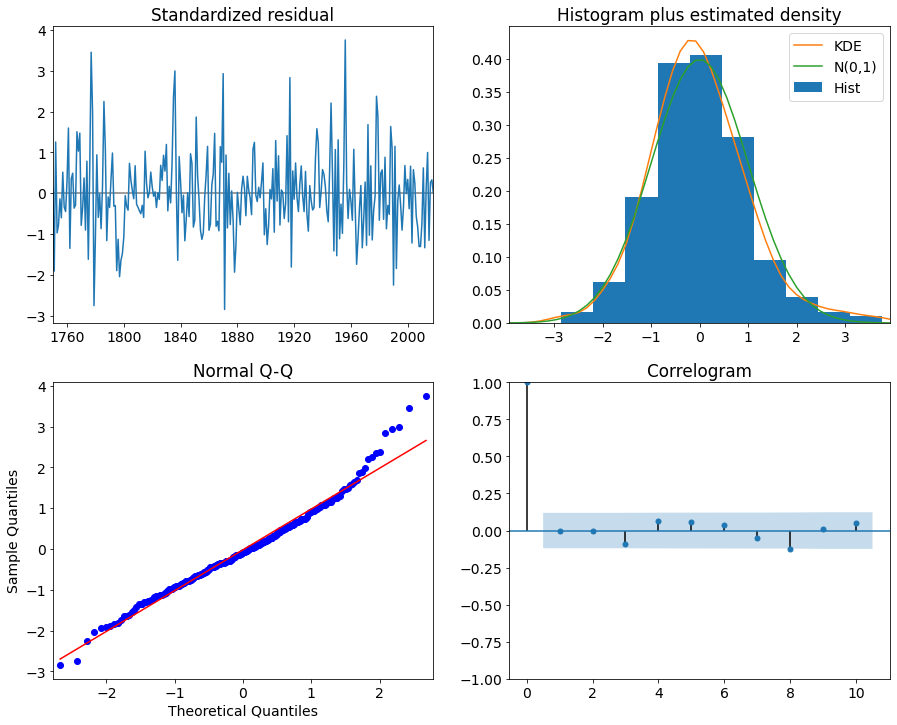

In [54]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

> The evaluation of the risiduals is looking good:
- There are no obvious patterns in the residuals.
- The KDE curve is very similar to the normal distribution
- Most of the data points of the Normal Q-Q lie on the straight line
- Correlogram: all correlations for lag greater than one are not significant except for lag 8.

##### Generating predictions

In [55]:
one_step_forecast = results.get_prediction(start=-len(df_testdata_yearly))

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Monthly_mean_total_sunspots']
upper_limits = confidence_intervals.loc[:,'upper Monthly_mean_total_sunspots']

# Print best estimate  predictions
print(mean_forecast.tail())

Date
2014-01-01    88.533919
2015-01-01    98.762901
2016-01-01    33.211744
2017-01-01    13.563464
2018-01-01     8.179967
Freq: AS-JAN, dtype: float64


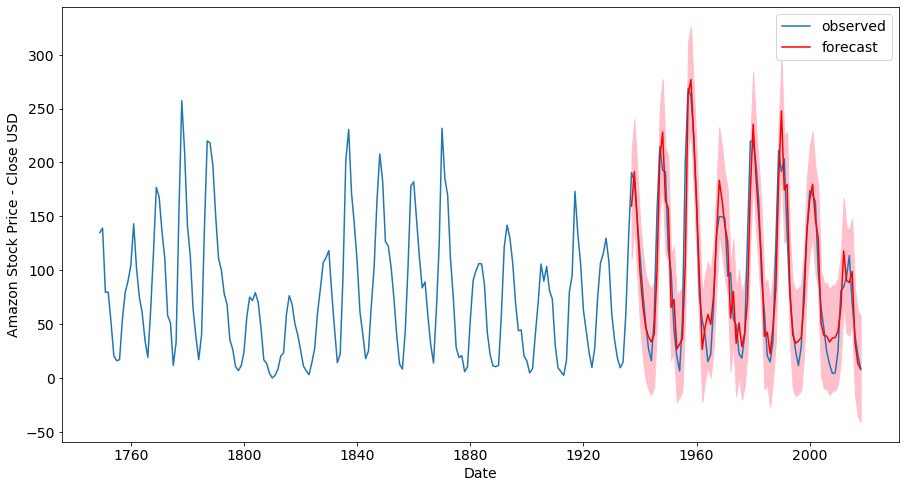

In [56]:
plt.plot(df_yearly.index, df_yearly, label='observed')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()

##### ARIMA forecast of next 25 values

In [57]:
arima_value_forecast = results.get_forecast(steps=25).predicted_mean

print(arima_value_forecast.tail(10))

2034-01-01    66.986601
2035-01-01    68.782777
2036-01-01    63.752911
2037-01-01    54.039133
2038-01-01    43.103275
2039-01-01    34.520902
2040-01-01    30.834955
2041-01-01    32.828918
2042-01-01    39.417367
2043-01-01    48.139680
Freq: AS-JAN, dtype: float64


In [58]:
df_arima_value_forecast = pd.DataFrame(arima_value_forecast)
df_arima_value_forecast.columns = ['near_future_forecast']

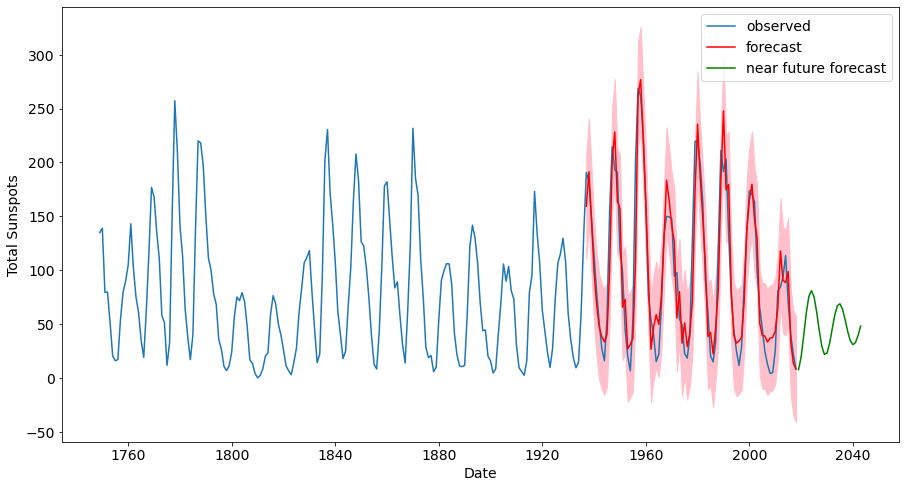

In [59]:
plt.plot(df_yearly.index, df_yearly, label='observed')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.plot(df_arima_value_forecast.index, df_arima_value_forecast, color='green', label='near future forecast')


# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Total Sunspots')
plt.legend()
plt.show()

> We have predicted 2 complete cycles with the ARIMA model. The peaks of the cycles are are visibly smaller than the last 3 peaks before July 2018. The prediction first reaches a minimum in 2019.  The first peak of sunspots will be reached at 2024. In 2029 the next minimum will be reached. That is about 10 years after the first minimum of the predicion and 1 year less then the 11 year solar cycle. The second peak is visibly smaller than the first one and will happen in 2036.



## Facebook Prophet Model

> To make long term predictions, we will use Facebook prophet. which has proven its value for long term predicitons. 

In [123]:
#'conda install pystan'

#'conda install -c conda-forge fbprophet'

In [124]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install fbprophet

In [126]:
from fbprophet import Prophet

##### Making the dataset 'Prophet' compliant

In [127]:
df_sunspots_fb = df_sunspots.reset_index()[['Date', 'Monthly_mean_total_sunspots']]
df_sunspots_fb.rename(columns={"Date": "ds", "Monthly_mean_total_sunspots": "y"}, inplace=True)
df_sunspots_fb.head()

,ds,y
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


#### Making predictions

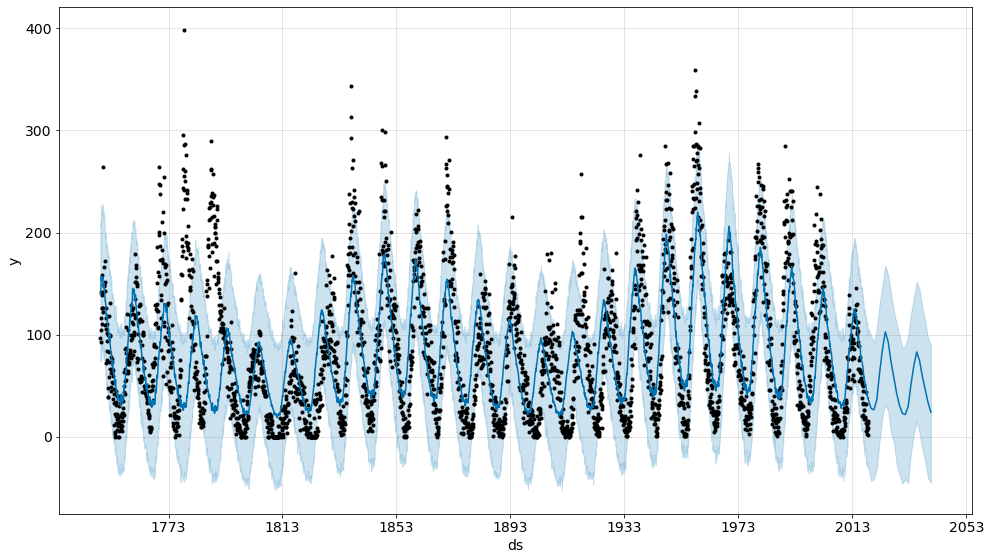

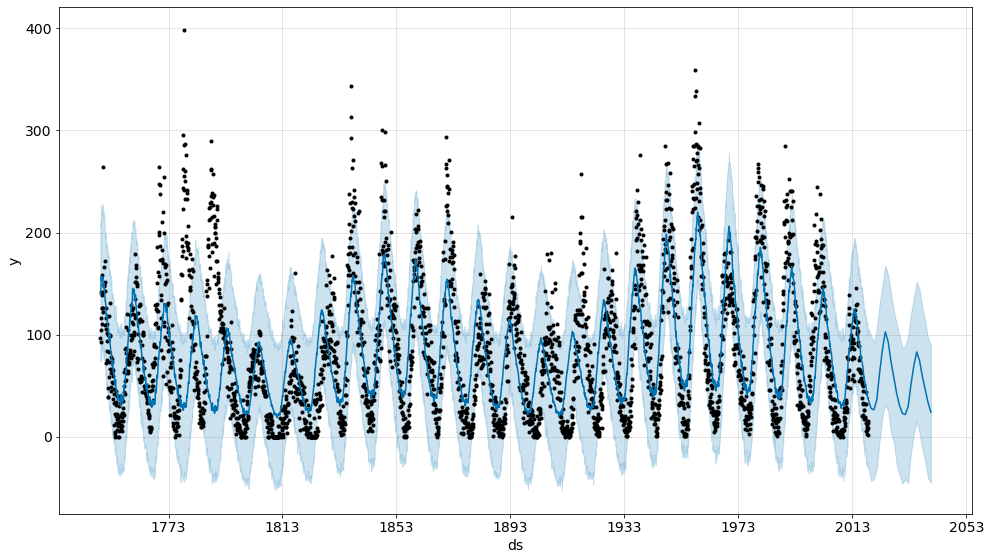

In [128]:
m1 = Prophet(seasonality_mode='multiplicative',daily_seasonality=False,weekly_seasonality=False)
m1.add_seasonality('cycle_11year', period=365.25 * 11,fourier_order=5)
m1.fit(df_sunspots_fb)
future = m1.make_future_dataframe(periods=22, freq='12M')
forecast = m1.predict(future)
m1.plot(forecast,figsize=(14,8))


###### Plotting the components

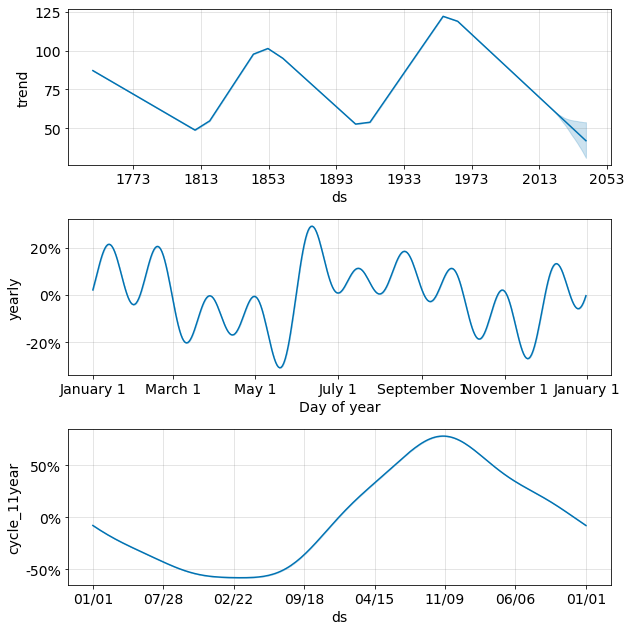

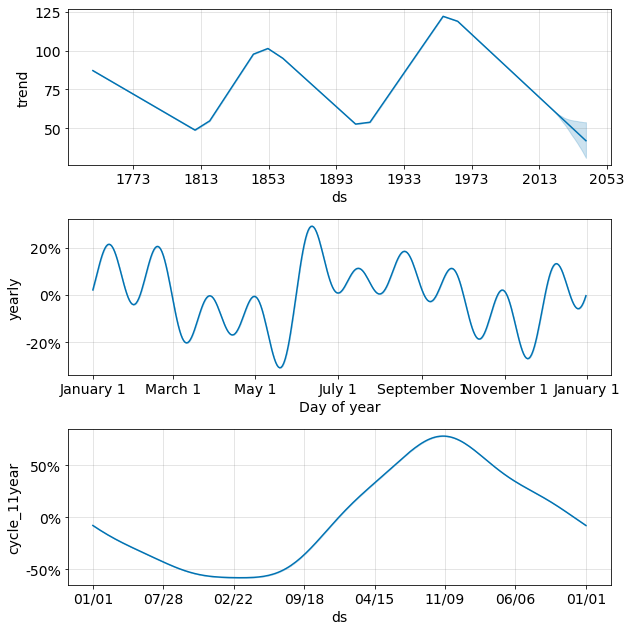

In [129]:
m1.plot_components(forecast)


In [130]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
3252,2036-07-31,74.790697,3.752894,144.288297
3253,2037-07-31,58.864028,-12.783766,126.943396
3254,2038-07-31,46.220190,-23.303370,113.526659
3255,2039-07-31,33.463908,-40.850115,96.073620
3256,2040-07-31,24.039900,-44.805724,89.497368


In [131]:
forecast.tail().T

,3252,3253,3254,3255,3256
ds,2036-07-31 00:00:00,2037-07-31 00:00:00,2038-07-31 00:00:00,2039-07-31 00:00:00,2040-07-31 00:00:00
trend,46.024161,45.010914,43.997667,42.98442,41.968397
yhat_lower,3.752894,-12.783766,-23.30337,-40.850115,-44.805724
yhat_upper,144.288297,126.943396,113.526659,96.07362,89.497368
trend_lower,38.469409,36.790267,34.928375,32.923911,30.907583
trend_upper,54.401052,54.266813,54.033904,53.898902,53.897959
cycle_11year,0.620837,0.303258,0.045537,-0.227069,-0.431384
cycle_11year_lower,0.620837,0.303258,0.045537,-0.227069,-0.431384
cycle_11year_upper,0.620837,0.303258,0.045537,-0.227069,-0.431384
multiplicative_terms,0.625031,0.307772,0.050515,-0.221487,-0.42719


##### Prediction of a certain month with confidence interval

In [132]:
yr = '2034-07-31'
print('Predictions for',yr)
print('Lower view:', forecast[forecast.ds == yr].iloc[0]['yhat_lower'])
print('View: ', forecast[forecast.ds == yr].iloc[0]['yhat'])
print('Upper view:', forecast[forecast.ds == yr].iloc[0]['yhat_upper'])

Predictions for 2034-07-31
Lower view: 2.960407126483365
View:  69.4775107645851
Upper view: 136.03568661998904


##### Zooming in on the forecast

In [133]:
forecast['ds']=pd.to_datetime(forecast['ds']) 
forecast = forecast.set_index('ds')


Text(0, 0.5, 'Total mean Sunspots')

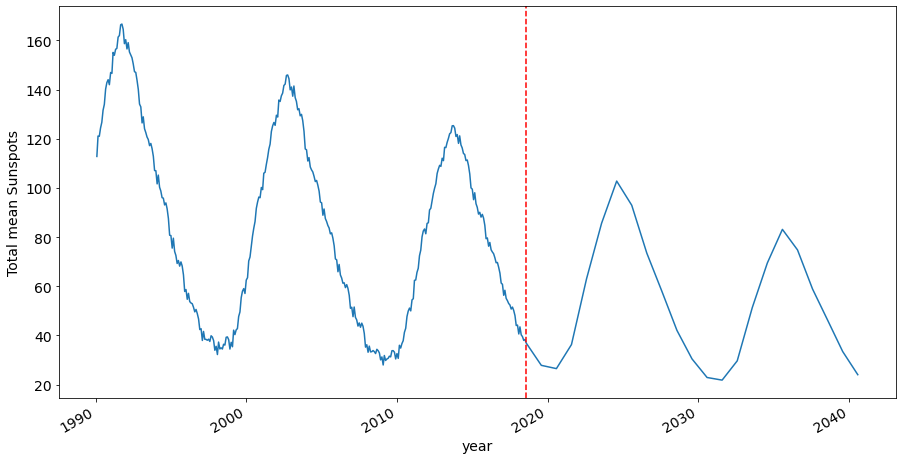

In [120]:
ax = forecast.loc['1990-01-31':,'yhat'].plot()

# Add a red vertical line to show where the prediciton starts
ax.axvline('2018-07-31', color='red', linestyle='--')
ax.set_xlabel('year')
ax.set_ylabel('Total mean Sunspots')




Text(0, 0.5, 'Total mean Sunspots')

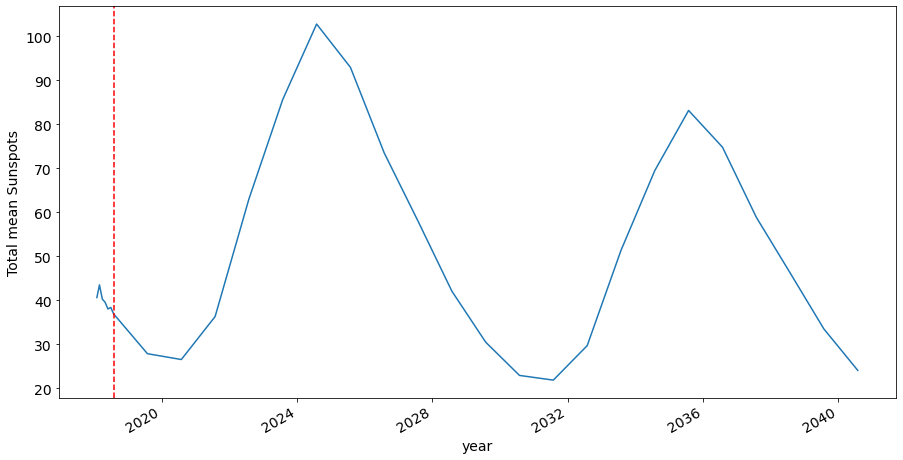

In [135]:
ax = forecast.loc['2018-01-31':,'yhat'].plot()

# Add a red vertical line to show where the prediciton starts
ax.axvline('2018-07-31', color='red', linestyle='--')
ax.set_xlabel('year')
ax.set_ylabel('Total mean Sunspots')


> We have predicted 2 complete cycles with the Facebook Prophet model. The peaks of the cycles are are visibly smaller than the last 3 peaks before July 2018. The prediction first goes to a minimum which will be reached between 2020 and 2021. The first peak of sunspots will be reached at 2025. Between 2031 and 2032 the second minimum will be reached. That is about 11 years after the first minimum of the predicion. The second peak is visibly smaller than the first one and will happen between 2035 and 2036.

> The occurance of 2 smaller peaks is in line with what we see in the predictions of the ARIMA model. The dates of the peaks and minima can differentiate somewhat for the ARIMA model.

# Conclusion and improvements

> Three different kinds of models have succesfully been developed. The predictive value of the Facebook Prophet model and the ARIMA model are higher than that of the naive forecast. Thanks to the models we have insights when the next solar cycles will take place. 

> There are still improvements to be done: 
- the results of the different models could be better compared to each other.
- different machine learning or deep learning models could be tested.